# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [2]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#Statiscal Parity: Sex, CIT, RAC1P

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

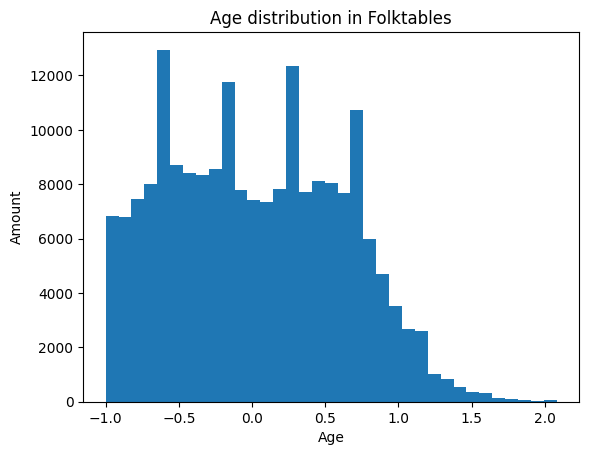

In [99]:
### Age plot to determine which kind of Scaler would be the most appropriate
data["AGEP"]
import matplotlib.pyplot as plt


plt.hist(data["AGEP"].values, bins = 35)
plt.title("Age distribution in Folktables")
plt.xlabel("Age")
plt.ylabel("Amount")

plt.show()


In [4]:
## We decideded on RobustScaler as we have quite skrewed distribution to the left
from sklearn.preprocessing import RobustScaler
age = data["AGEP"].values.reshape(-1,1)
transformer = RobustScaler().fit(age)
age = transformer.transform(age)

data["AGEP"] = age
print(data["AGEP"])

0        -0.48
6        -0.84
7         0.92
10       -0.36
13       -0.96
          ... 
378801   -0.16
378802   -0.12
378807    0.76
378811    1.08
378813   -0.08
Name: AGEP, Length: 195665, dtype: float64


In [154]:


X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

In [155]:
from sklearn.linear_model import LogisticRegression

LogR = LogisticRegression(max_iter=5000, penalty ="l2", C= 0.8497534359086438, tol = 1e-4, solver = "saga").fit(X_train, y_train)

LogR.predict(X_test)
LogR.predict_proba(X_test)
LogR.score(X_test, y_test)


0.7696062147037027

#Answers: 
- Train a logistic regression, The age is rescaled with RobustScaler as the age it heavily right tailed skrewed. In this case we have few people with age 70,80,90 relatively to age 20,30,40... 
- Score 76.961 %


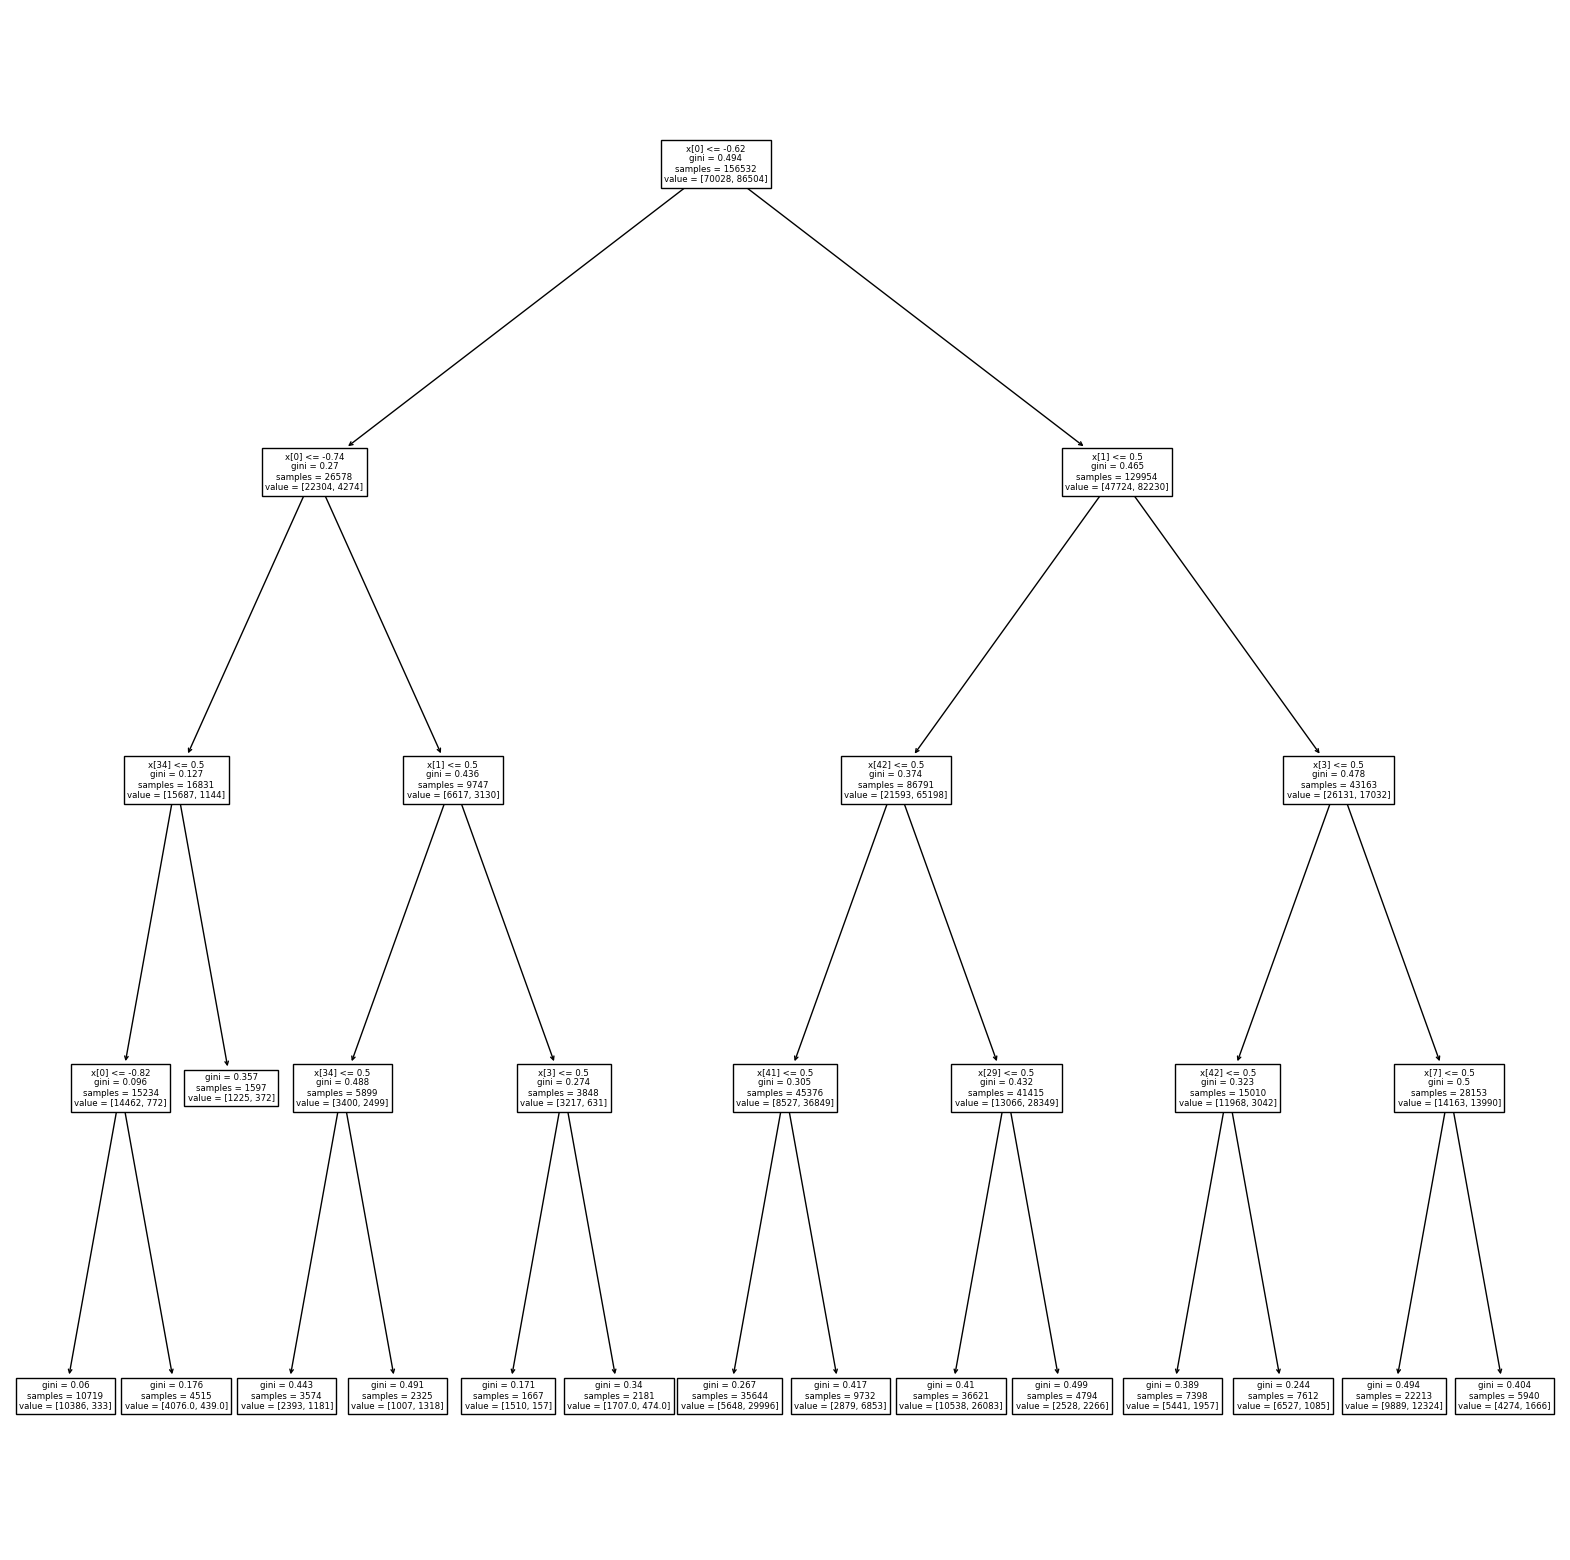

In [156]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(min_samples_split = 0.01, min_samples_leaf= 0.01,  max_depth = 4, criterion = "gini", random_state = 0)
clf = clf.fit(X_train, y_train)

plt.figure(figsize=(20,20))

tree.plot_tree(clf)
plt.show()


In [157]:
#X_train.columns

clf.score(X_test, y_test)

0.7469399228272813

In [158]:
import dtreeviz
import graphviz

<module 'dtreeviz.models' from 'c:\\Users\\User\\miniconda3\\lib\\site-packages\\dtreeviz\\models\\__init__.py'>


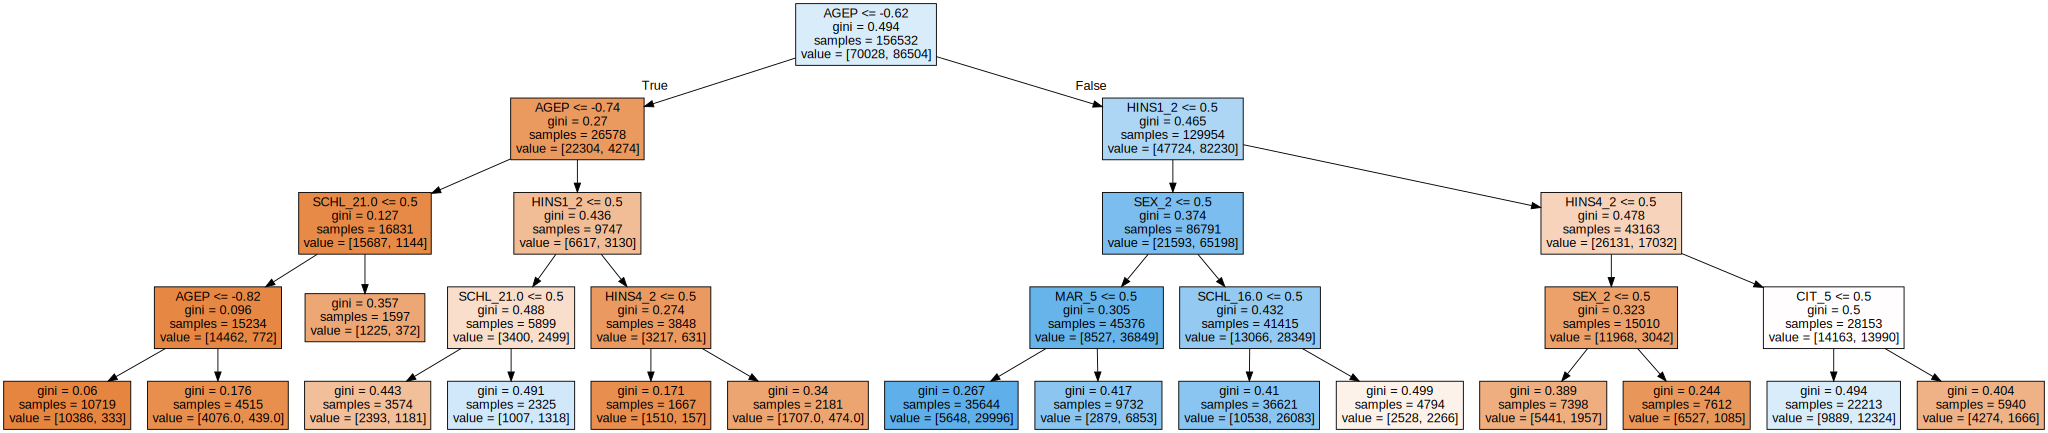

In [159]:
from sklearn import tree
print(dtreeviz.models)
# DOT data
dot_data = tree.export_graphviz(clf, 
                                feature_names=X_train.columns,  
                                #class_names=iris.target_names,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [277]:
#https://github.com/parrt/dtreeviz/blob/master/notebooks/dtreeviz_sklearn_pipeline_visualisations.ipynb
viz_model = dtreeviz.model(clf, tree_index=1,
                           X_train = X_train, y_train = y_train,
                           feature_names=X_train.columns,
                           target_name=target_name)

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


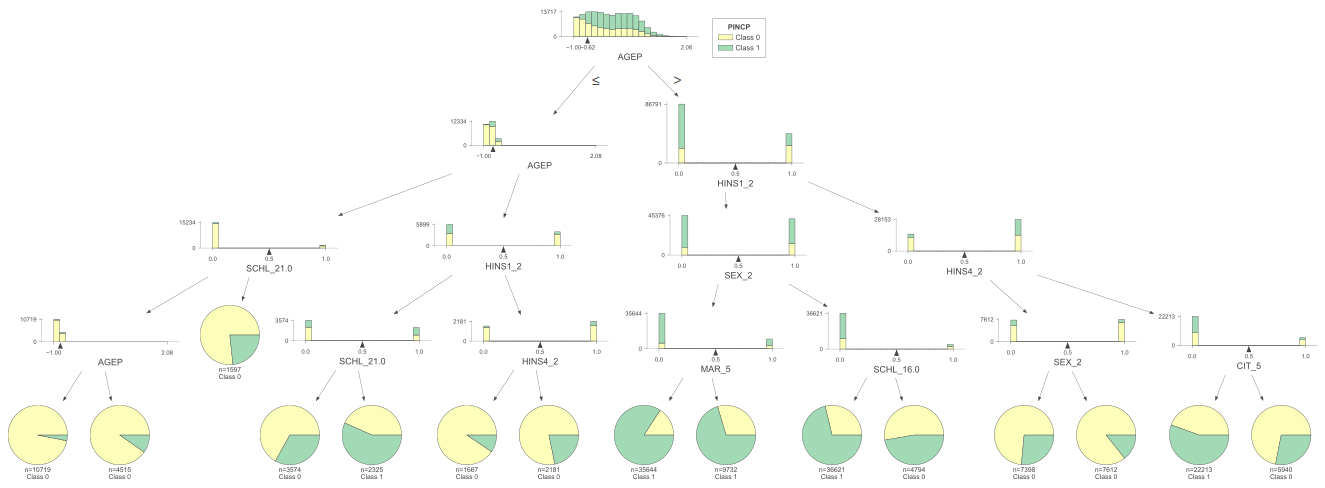

In [278]:
### To get specfic instance
# x = x_train.iloc[???]
#viz_model.view(x=x)

viz_model.view()

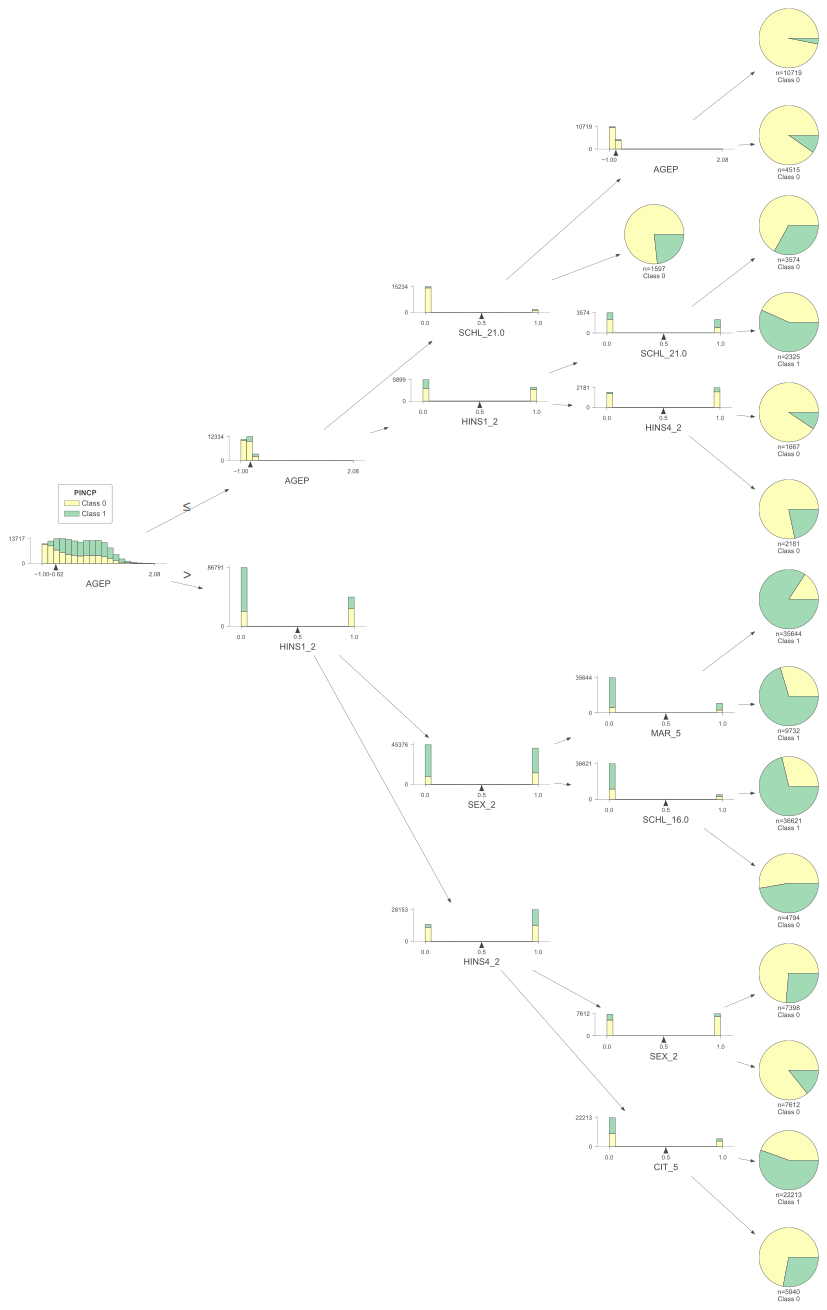

In [162]:
viz_model.view(orientation="LR")

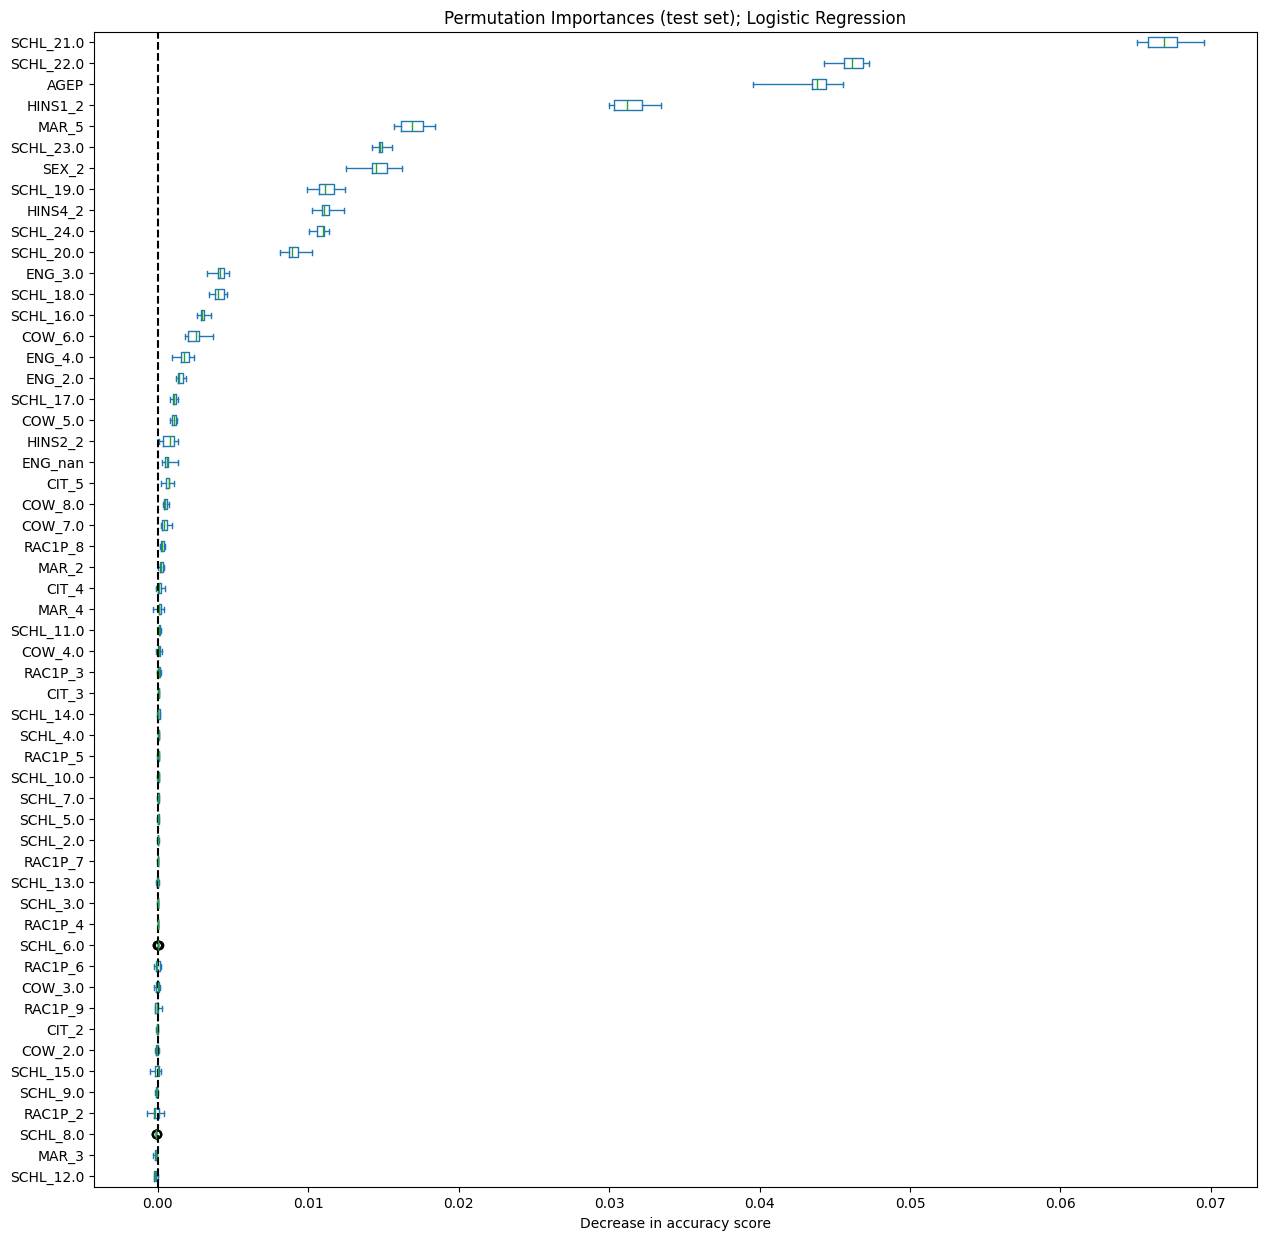

In [163]:
from sklearn.inspection import permutation_importance
LogR = LogisticRegression(max_iter=5000, penalty ="l2", C= 0.8497534359086438, tol = 1e-4, solver = "saga").fit(X_train, y_train)
#permutation_importance(LogR, X_test, y_test, n_repeats = 30, random_state = 0)
result = permutation_importance(
    LogR, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)

# Set the figure size
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the boxplot
importances.plot.box(ax=ax, vert=False, whis=10)
ax.set_title("Permutation Importances (test set); Logistic Regression")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")

plt.show()



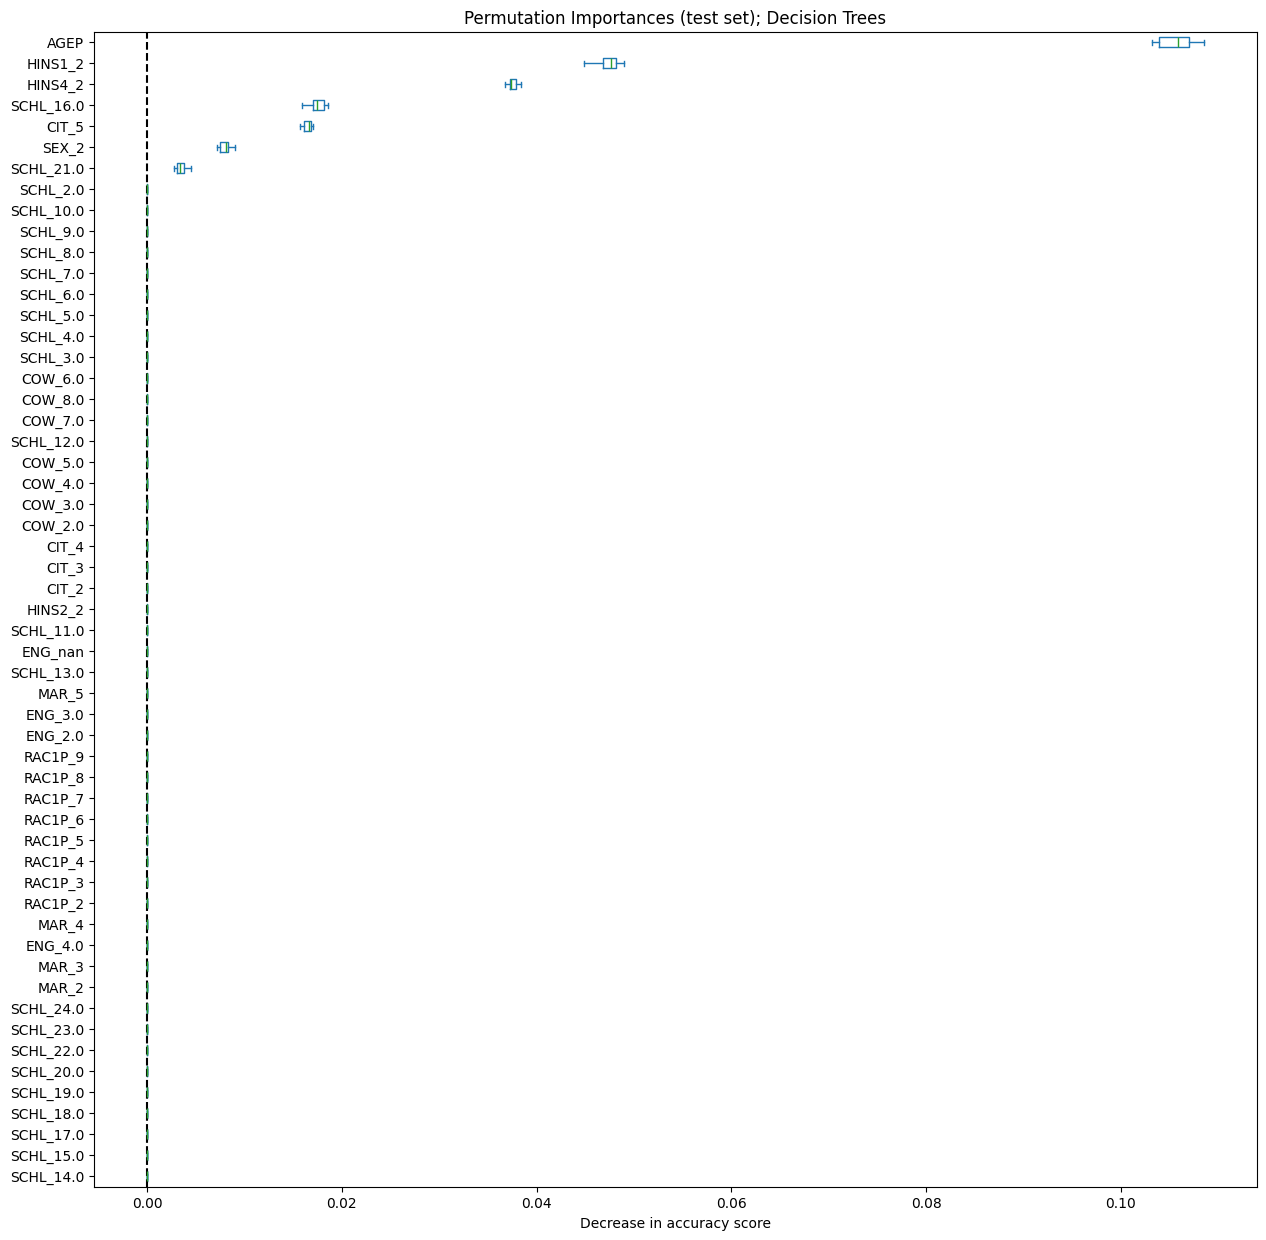

In [164]:
from sklearn.inspection import permutation_importance
#LogR = LogisticRegression(max_iter=5000, penalty ="l2", C= 0.8497534359086438, tol = 1e-4, solver = "saga").fit(X_train, y_train)
#permutation_importance(LogR, X_test, y_test, n_repeats = 30, random_state = 0)
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
# Set the figure size
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the boxplot
importances.plot.box(ax=ax, vert=False, whis=10)
ax.set_title("Permutation Importances (test set); Decision Trees")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")

plt.show()



In [165]:
#!pip install shap
import shap

In [166]:
data

,AGEP,HINS1_2,HINS2_2,HINS4_2,CIT_2,CIT_3,CIT_4,CIT_5,COW_2.0,COW_3.0,...,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,ENG_2.0,ENG_3.0,ENG_4.0,ENG_nan
0,-0.48,True,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
6,-0.84,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
7,0.92,True,True,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
10,-0.36,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13,-0.96,True,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378801,-0.16,False,True,True,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
378802,-0.12,False,True,True,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
378807,0.76,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
378811,1.08,True,True,True,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [167]:
X_test

,AGEP,HINS1_2,HINS2_2,HINS4_2,CIT_2,CIT_3,CIT_4,CIT_5,COW_2.0,COW_3.0,...,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,ENG_2.0,ENG_3.0,ENG_4.0,ENG_nan
309375,0.80,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
197073,-0.36,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
306289,-0.36,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
173749,0.16,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
57936,-0.40,False,True,True,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372590,-0.40,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
272674,1.68,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
207697,0.92,False,True,True,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
38489,0.84,True,False,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Critique of SHAP

- Explainability is not SHAP's game, Relative importance of features 
- 

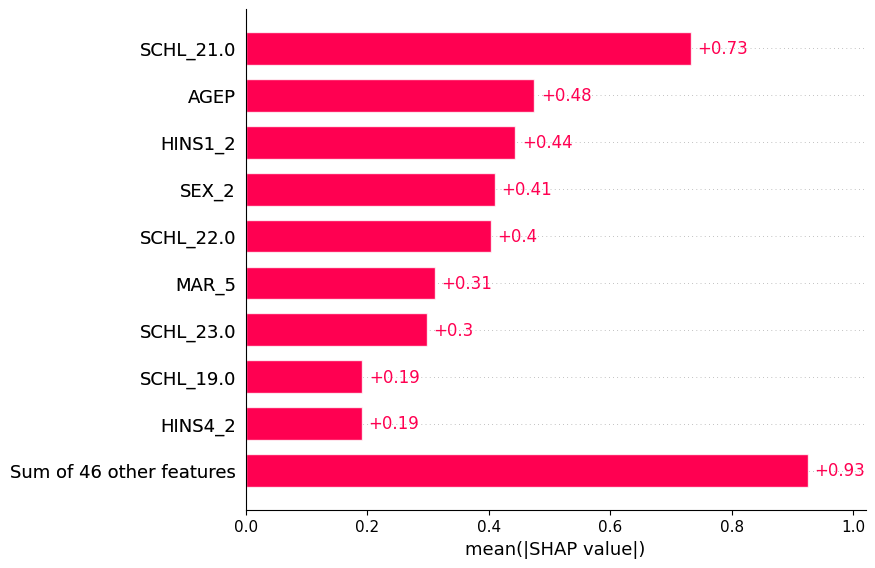

In [272]:
############# SHAP ################
## Logistic Regression, bar plot: 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=1)
X_vec = vectorizer.fit_transform(X_train)

explainer = shap.Explainer(
    LogR, X_train, feature_names=vectorizer.get_feature_names_out()
)
shap_values = explainer(X_test)
shap.plots.bar(shap_values_LogR)


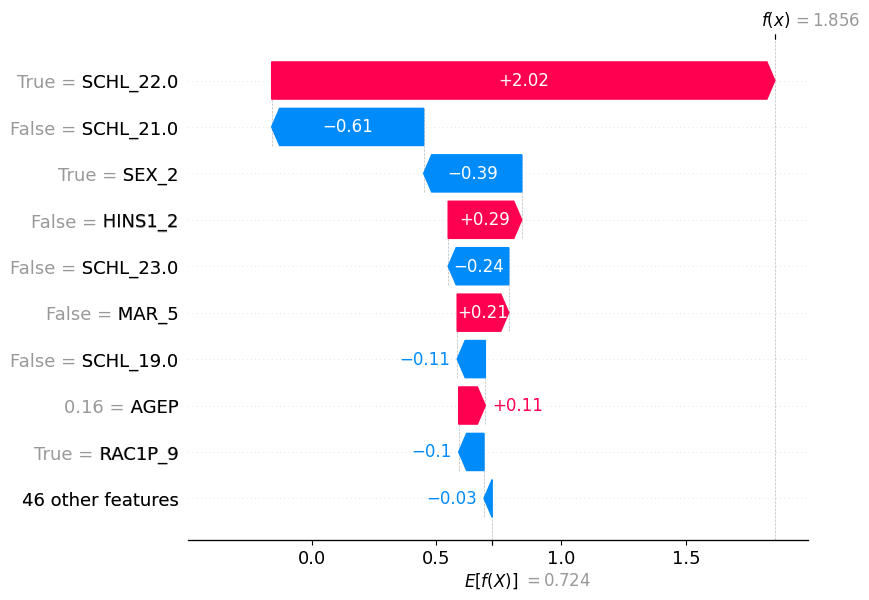

In [279]:
############# SHAP ################
## Logistic Regression, Waterfall plot: 
shap.plots.waterfall(shap_values_LogR[0])


In [261]:
shap.initjs()
shap.plots.force(shap_values_LogR[0], link = "logit")


In [169]:
print(len(shap_values.values))
#for i in shap_values.values: 
#    print(i)

39133


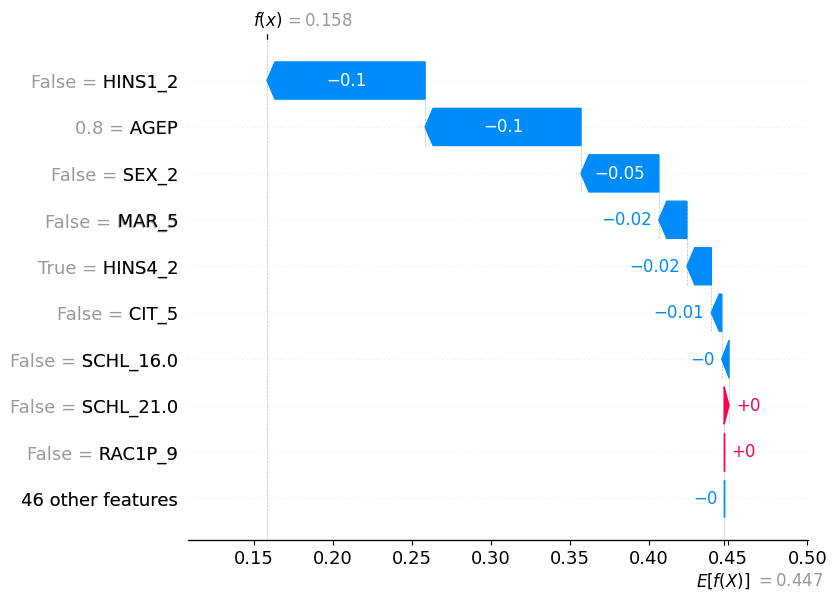

In [251]:
import shap

# Assuming you already have your clf model and data prepared
# Compute SHAP values

##Instance idx does not matter. Can be 0 and 1 
##Output idx does matter. Reverse the numbers from E(f(x)). Can be 0 and 1


explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

instance_idx =0
output_idx = 0

# Create an Explanation object for the selected instance and output
expected_value = explainer.expected_value[output_idx]
explanation = shap.Explanation(shap_values[output_idx][instance_idx], base_values=expected_value, data=X_test.iloc[instance_idx])

# Generate the waterfall plot
shap.plots.waterfall(explanation)

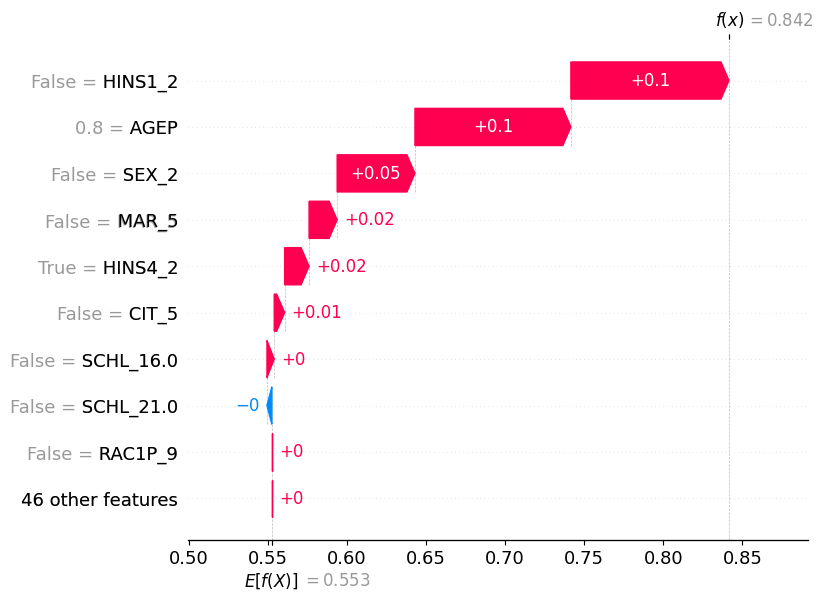

In [265]:

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

instance_idx =0
output_idx = 1

# Create an Explanation object for the selected instance and output
expected_value = explainer.expected_value[output_idx]
explanation = shap.Explanation(shap_values[output_idx][instance_idx], base_values=expected_value, data=X_test.iloc[instance_idx])

# Generate the waterfall plot
shap.plots.waterfall(explanation)

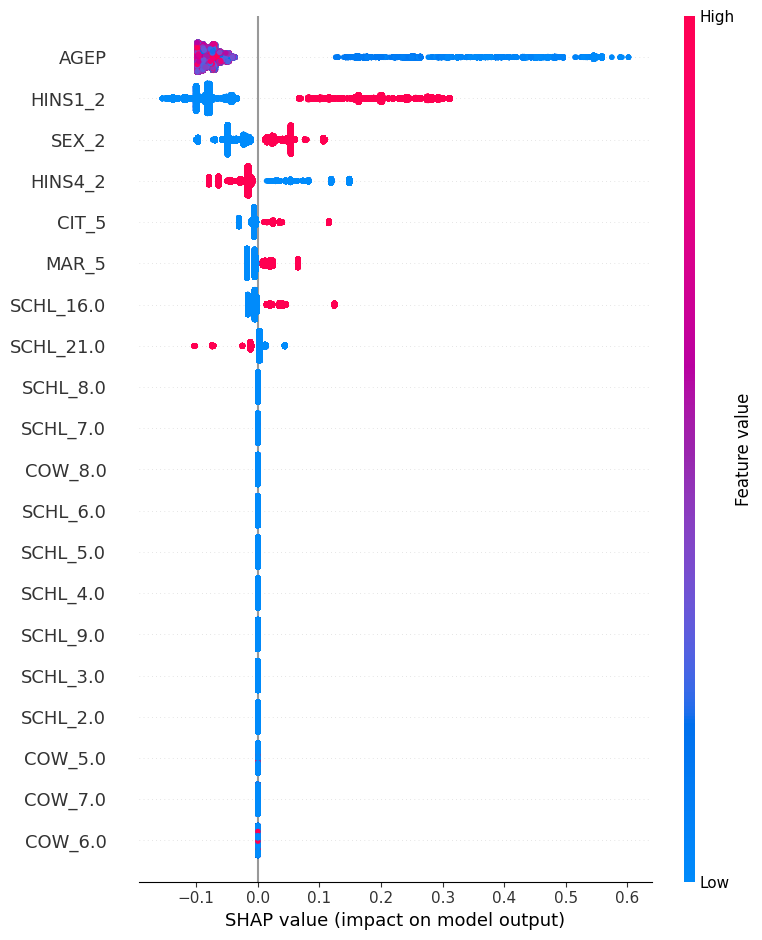

In [287]:
# explain all the predictions in the test set
ex = shap.TreeExplainer(clf)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values[0], X_test, feature_names = data.columns)

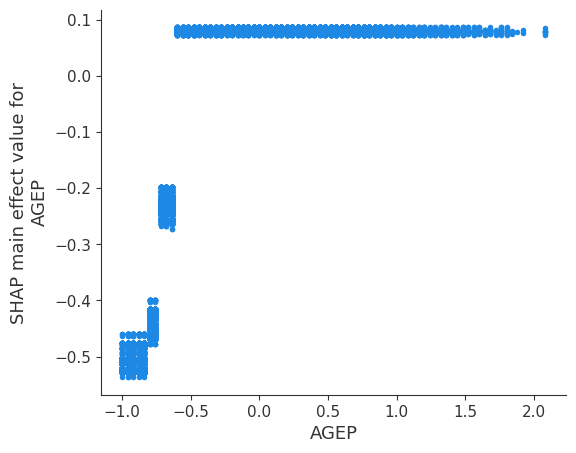

In [289]:

explainer = shap.TreeExplainer(clf, model_output = "raw")
shap_interaction_values = explainer.shap_interaction_values(X_test)
shap.dependence_plot(("AGEP", "AGEP"), shap_interaction_values[1], X_test)


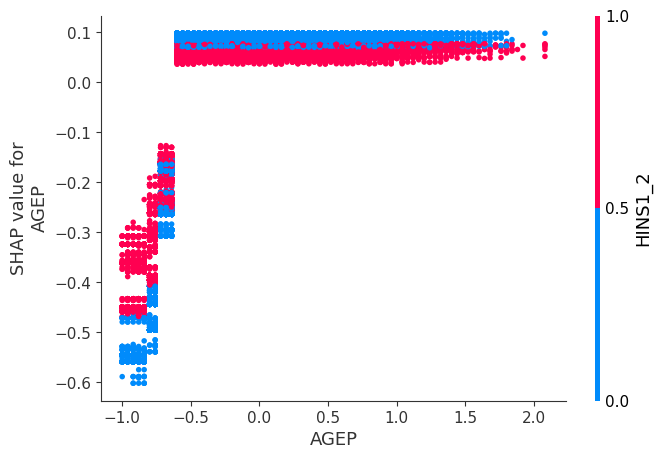

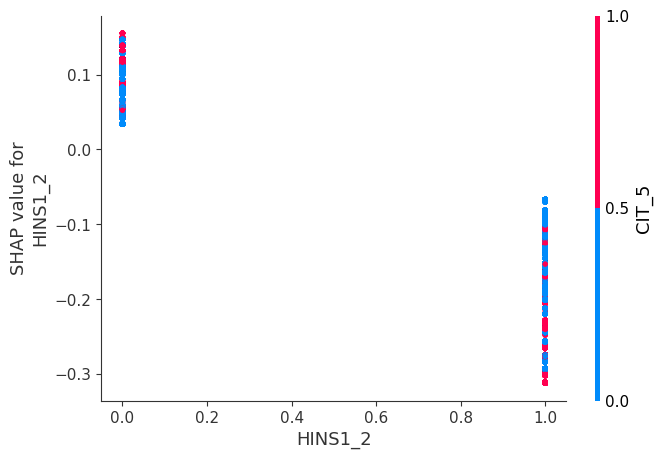

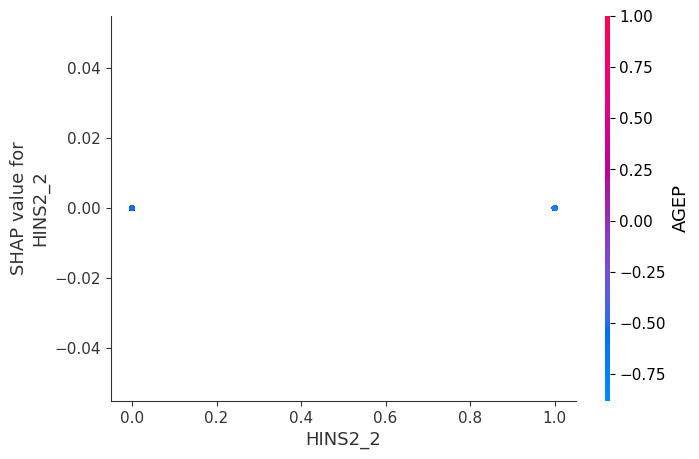

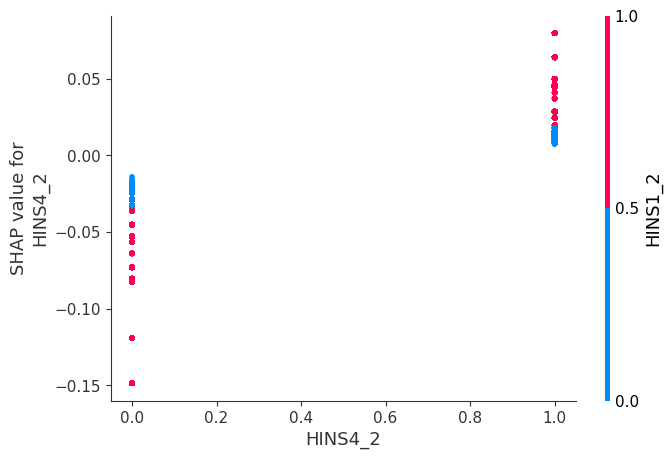

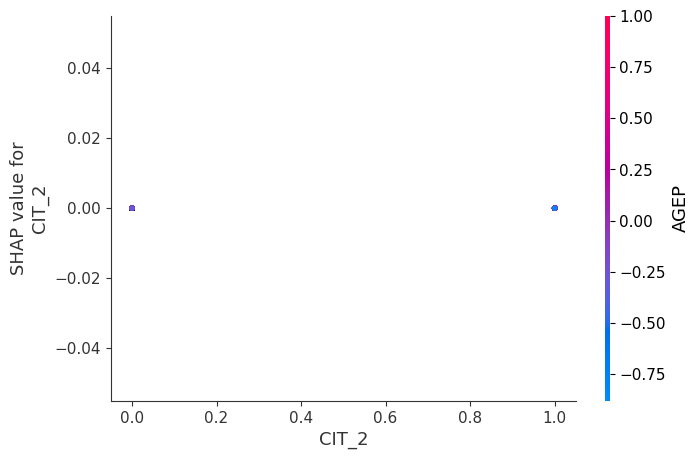

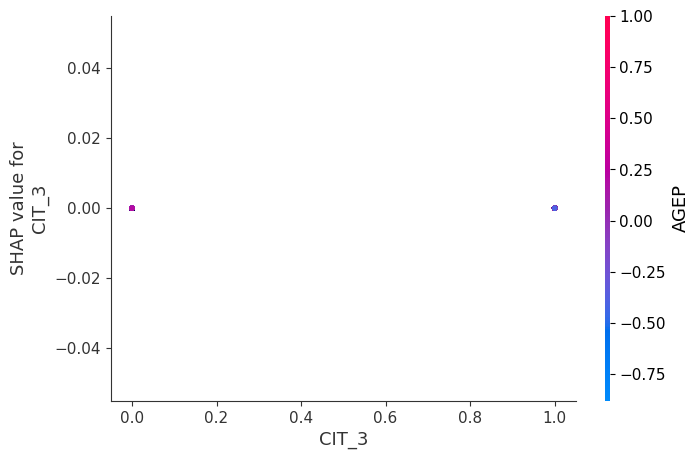

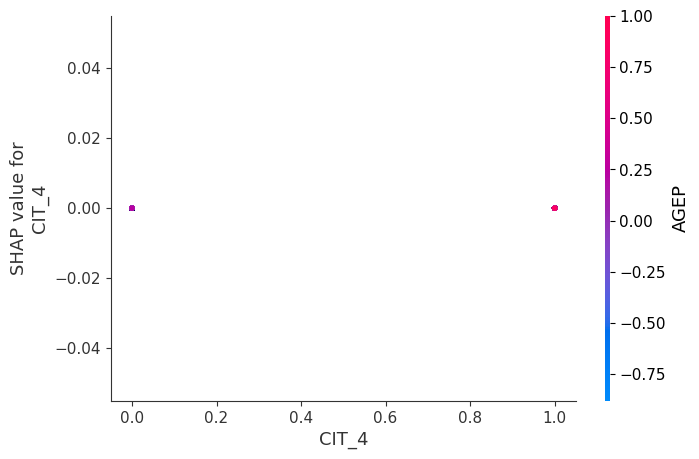

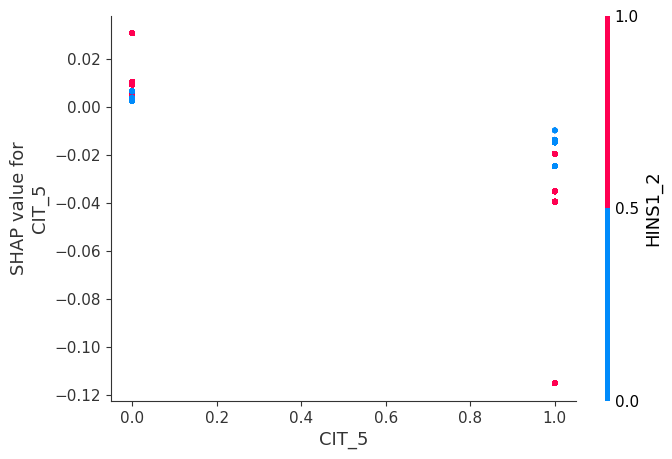

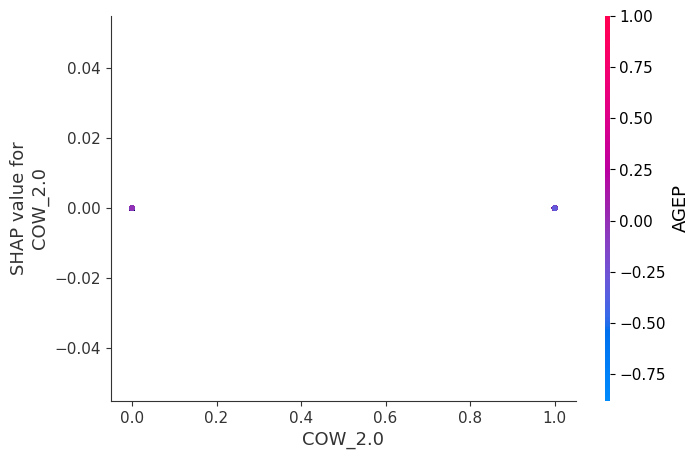

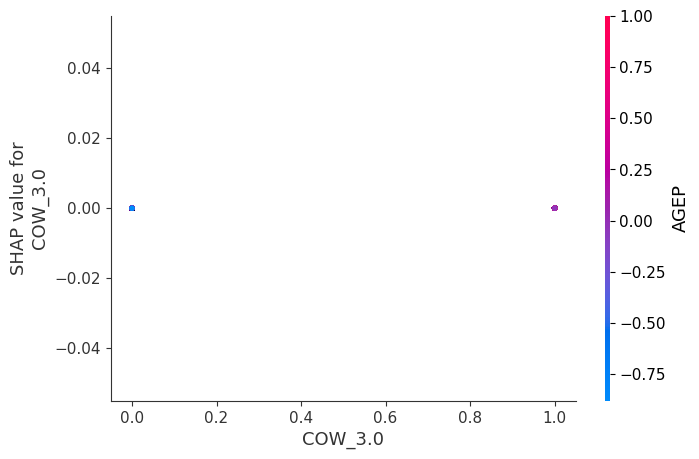

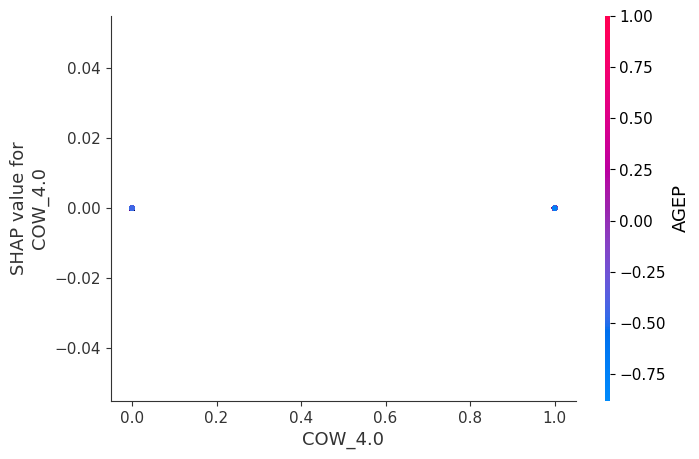

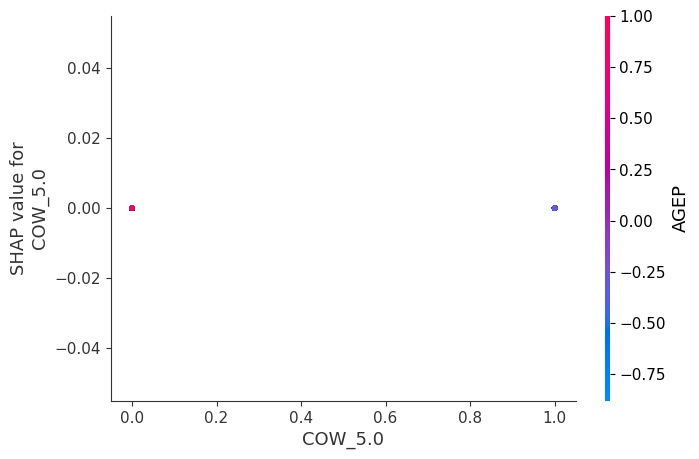

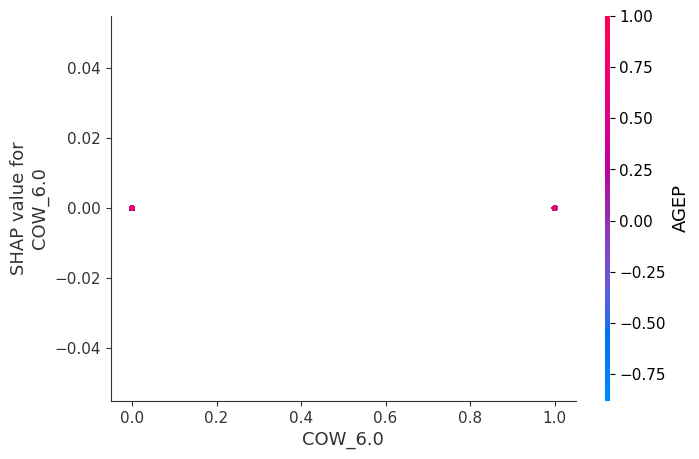

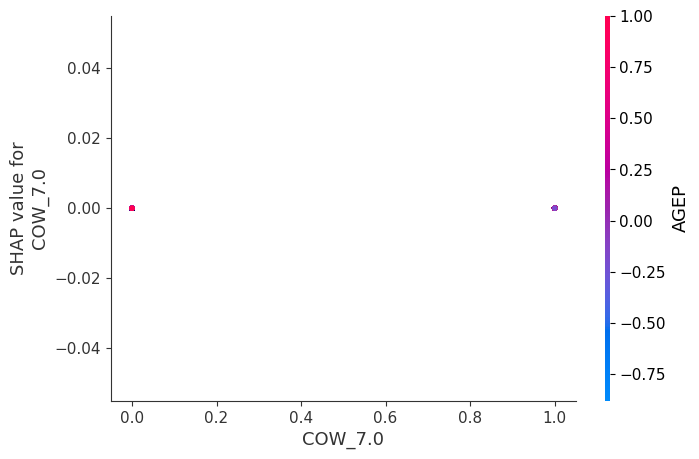

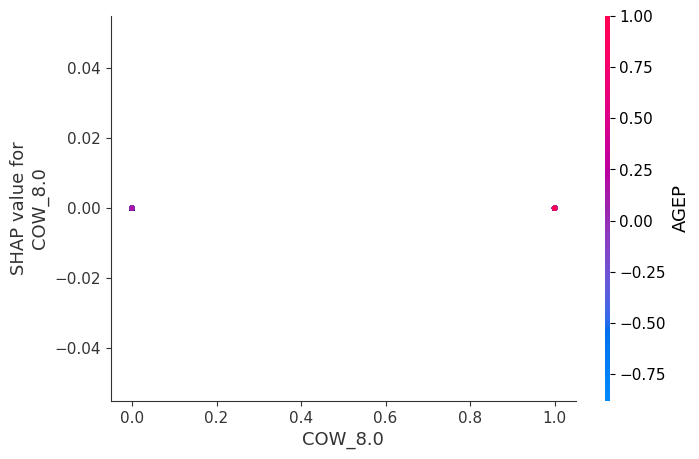

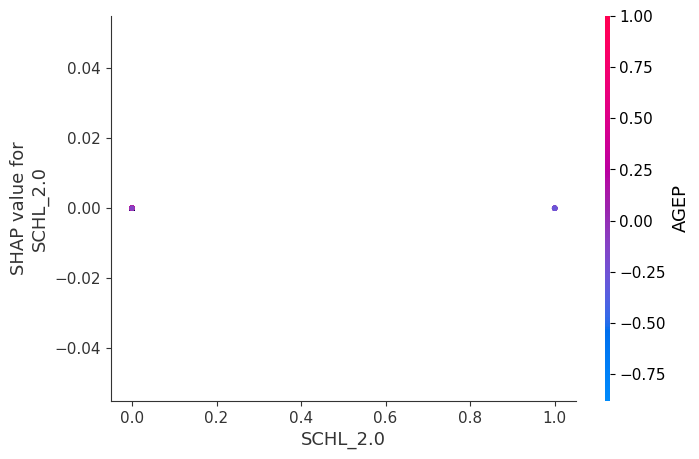

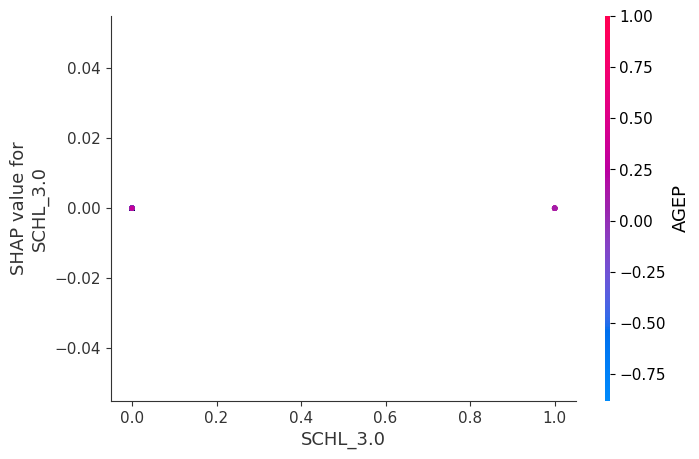

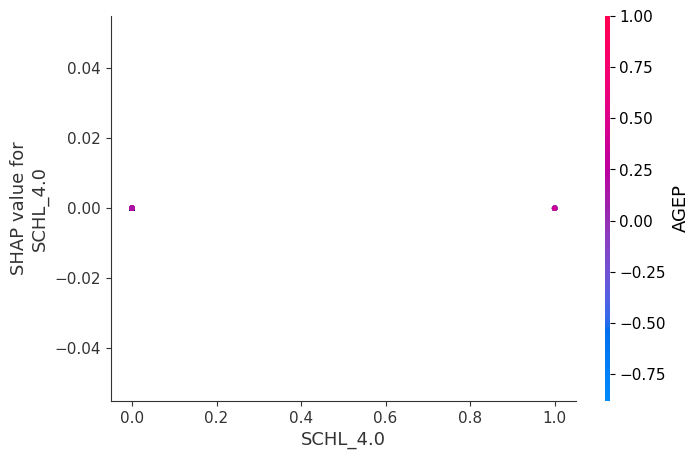

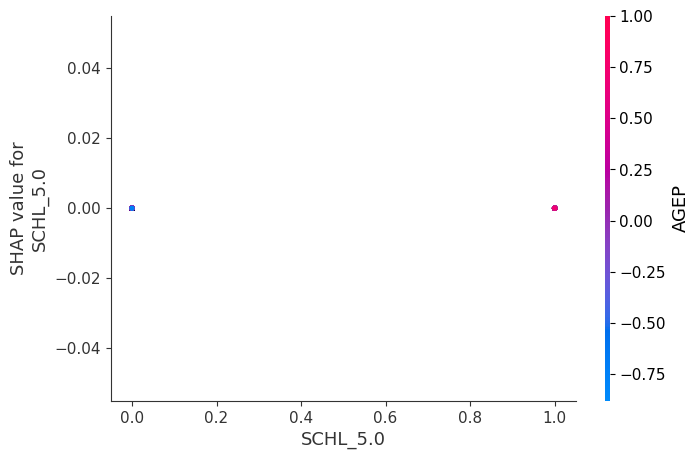

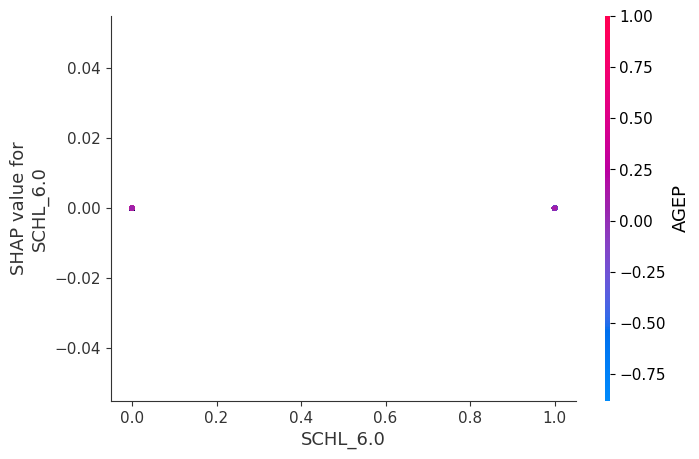

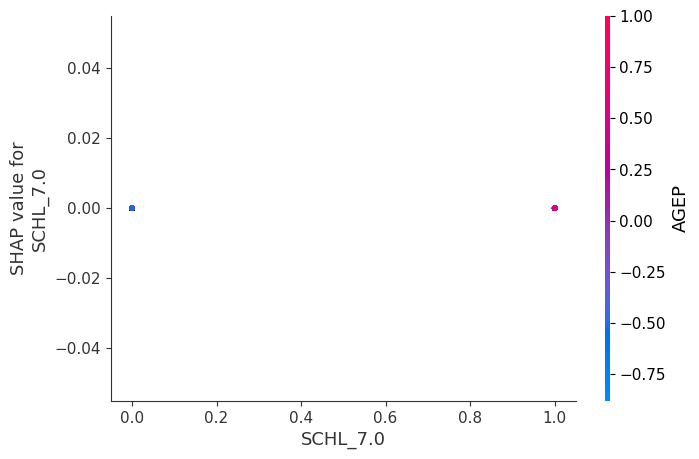

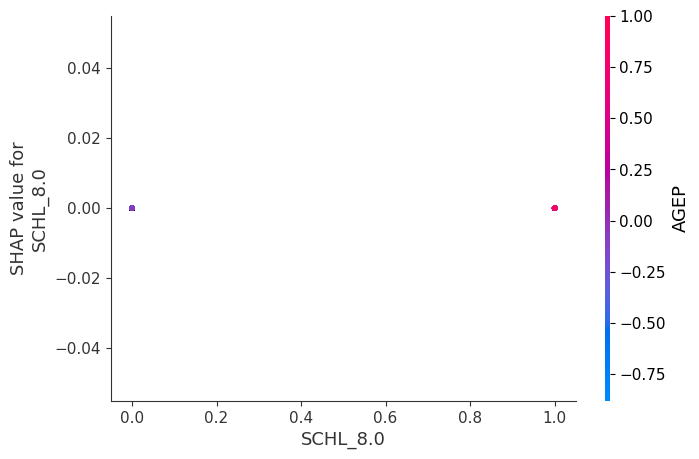

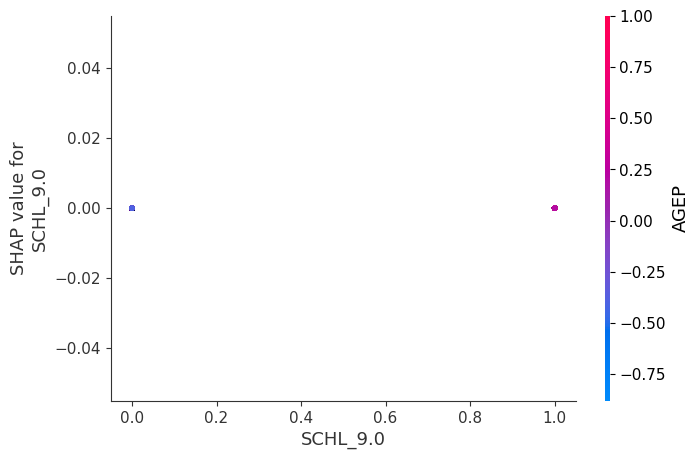

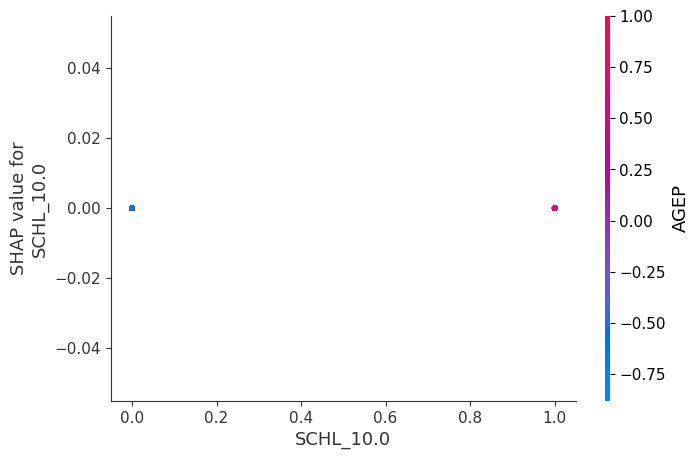

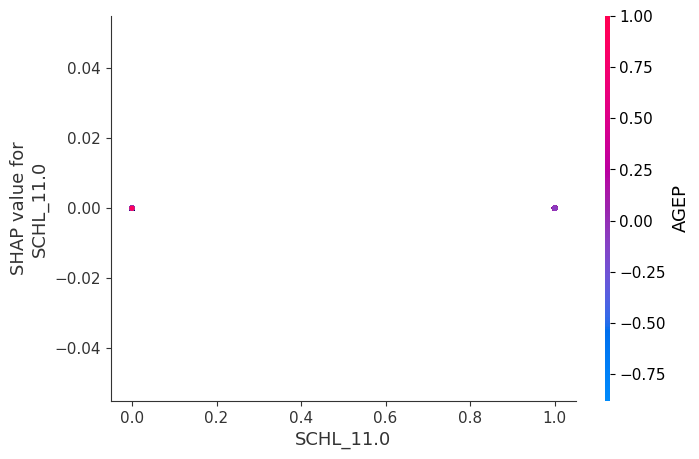

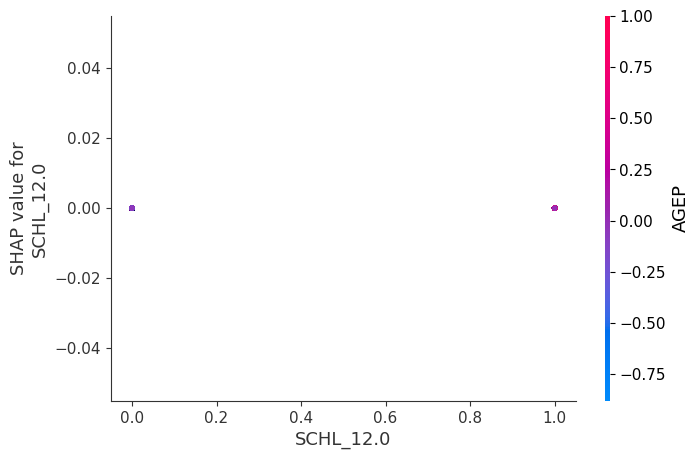

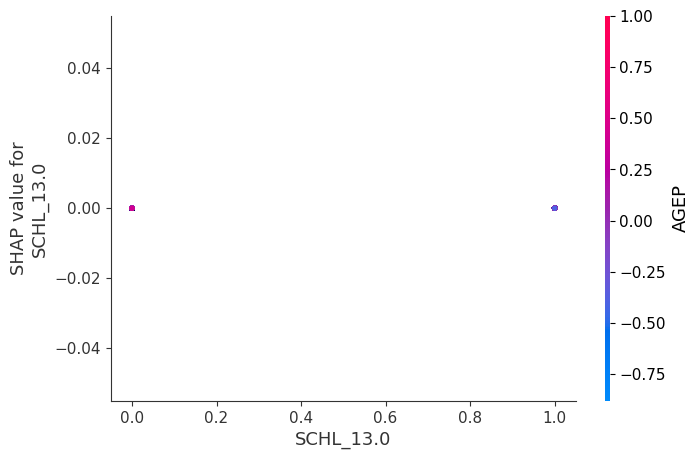

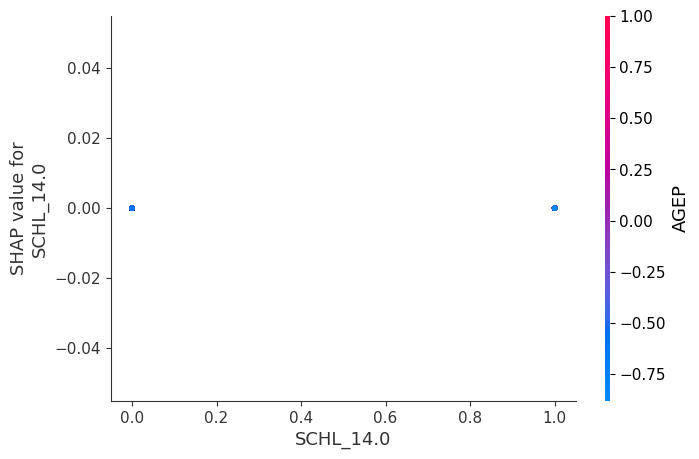

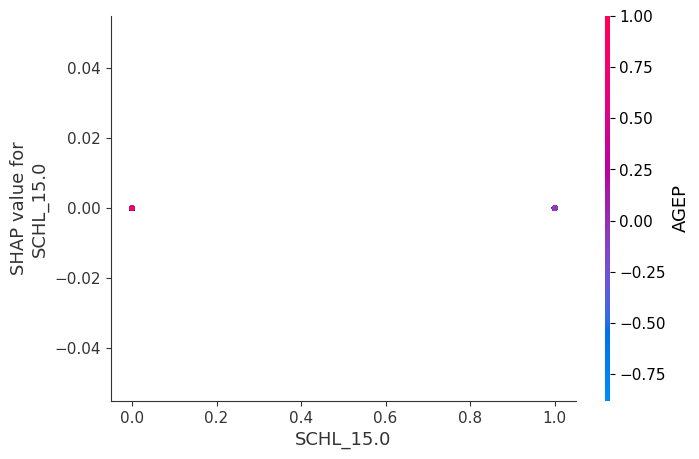

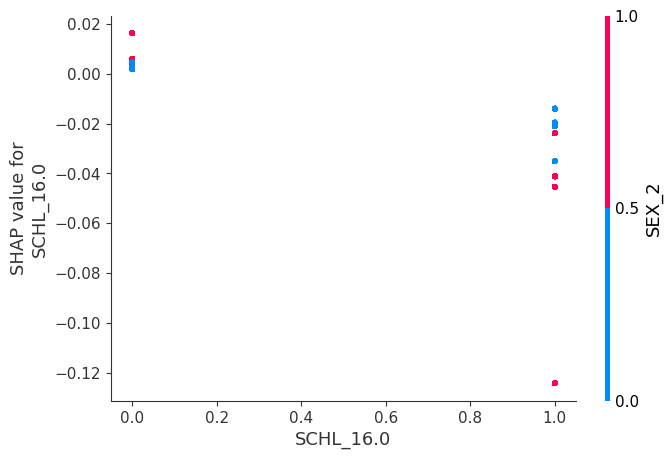

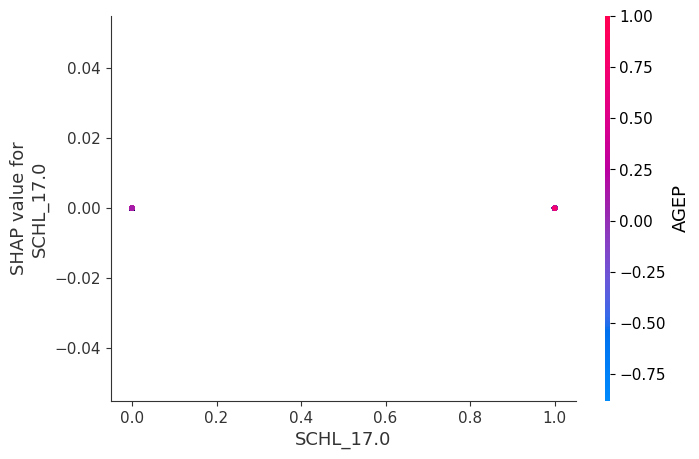

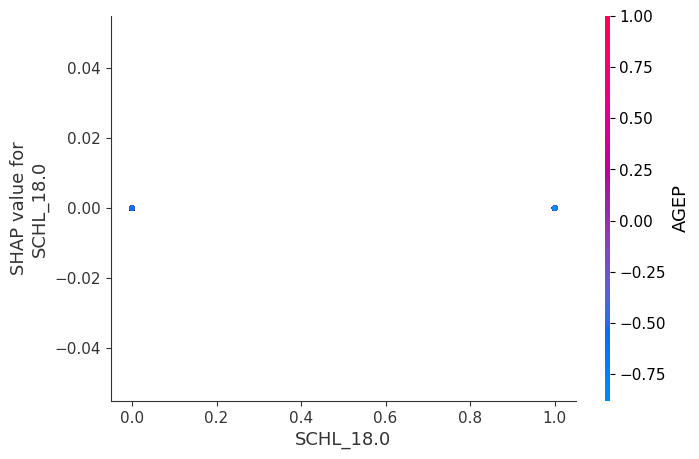

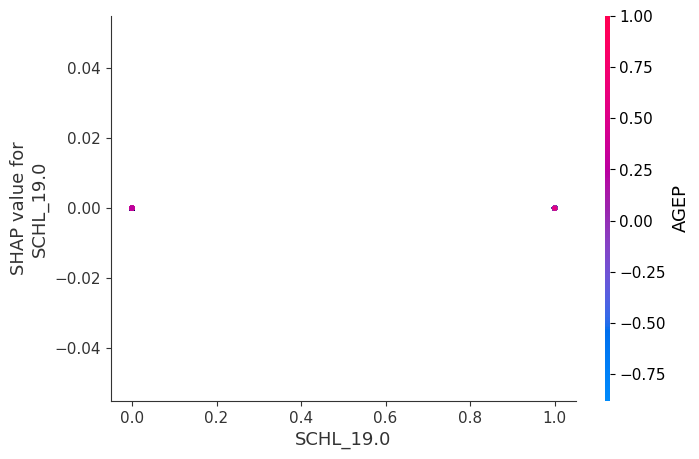

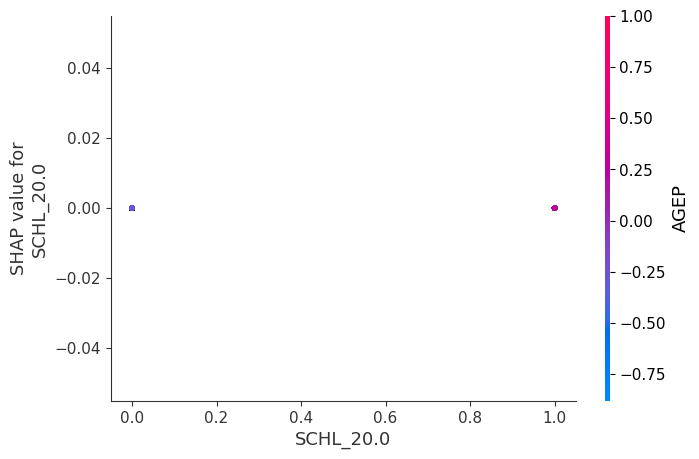

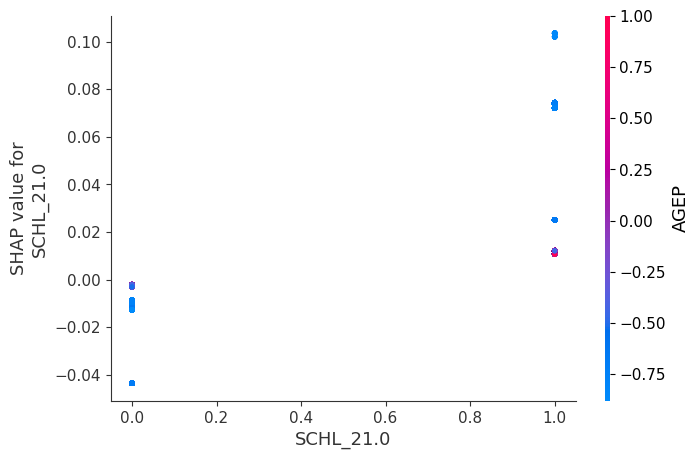

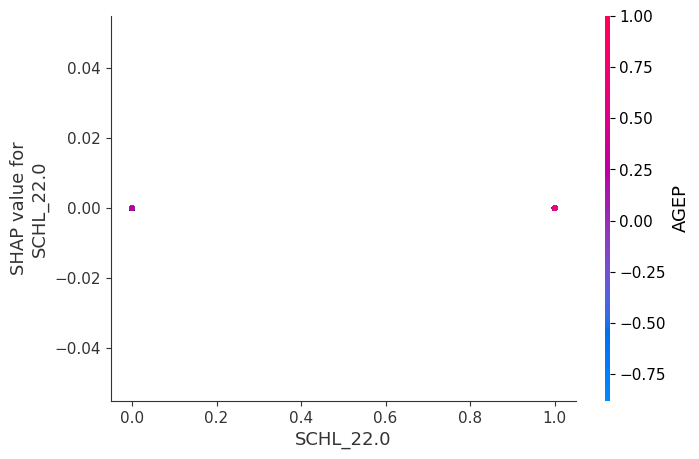

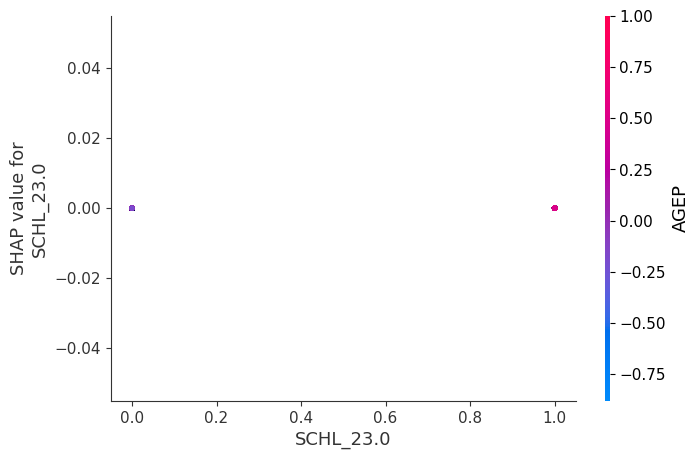

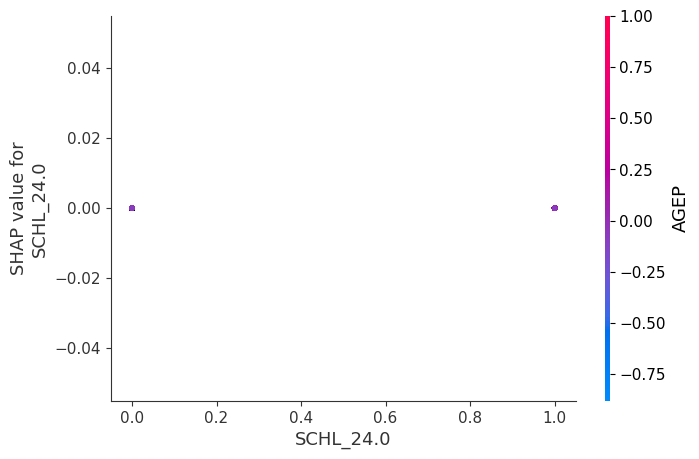

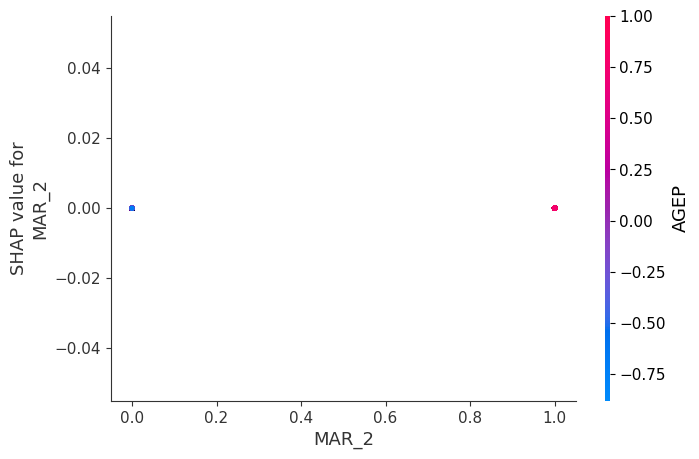

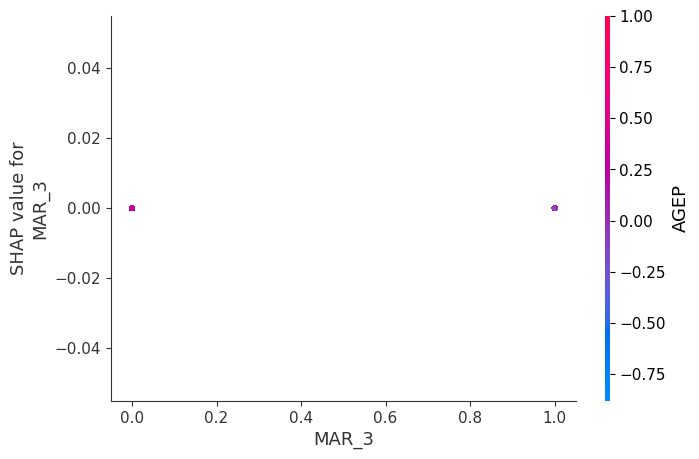

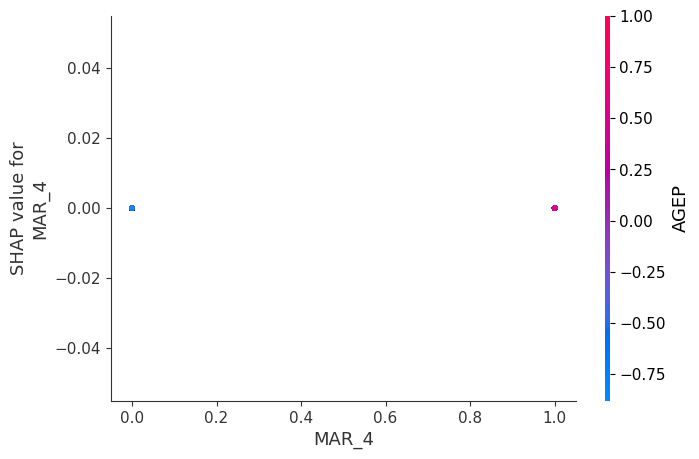

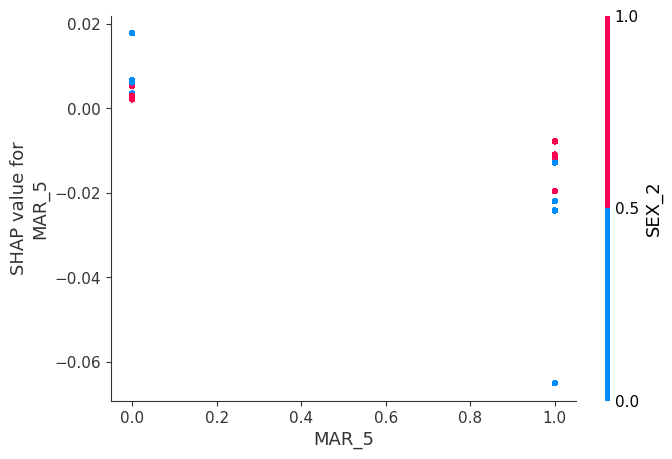

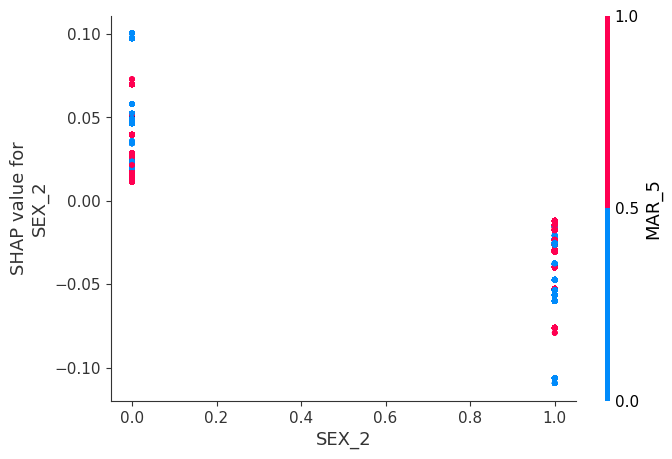

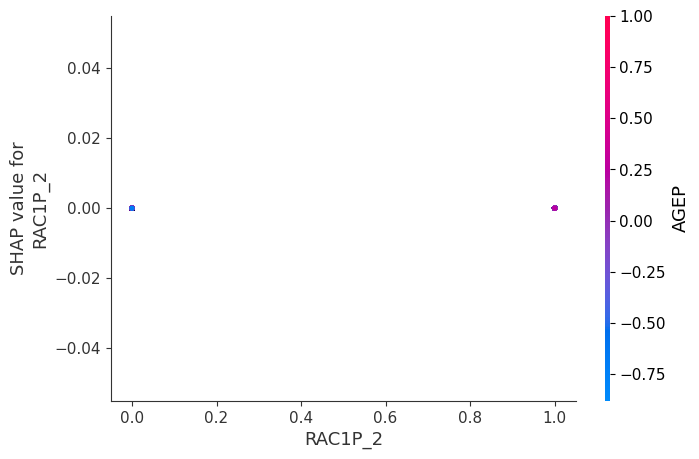

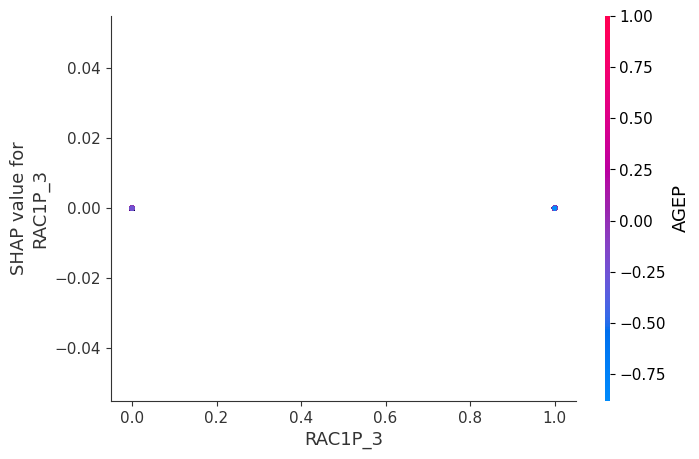

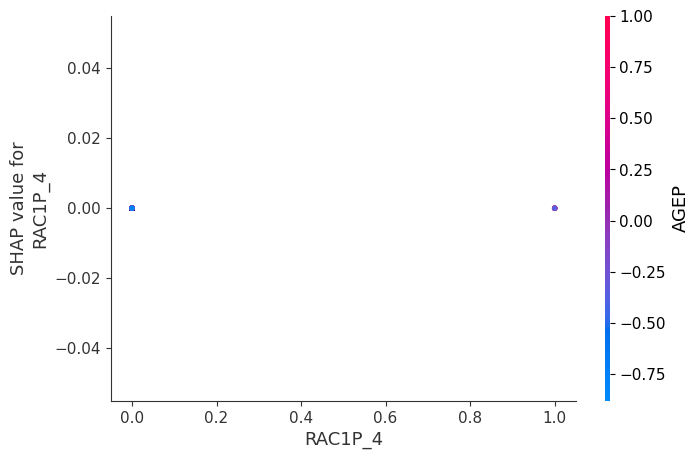

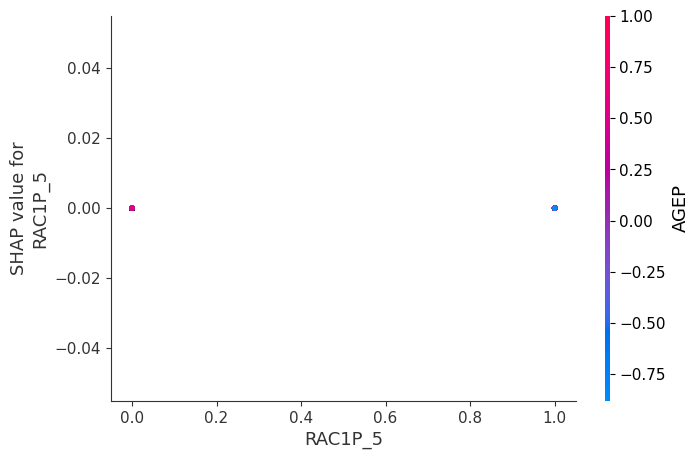

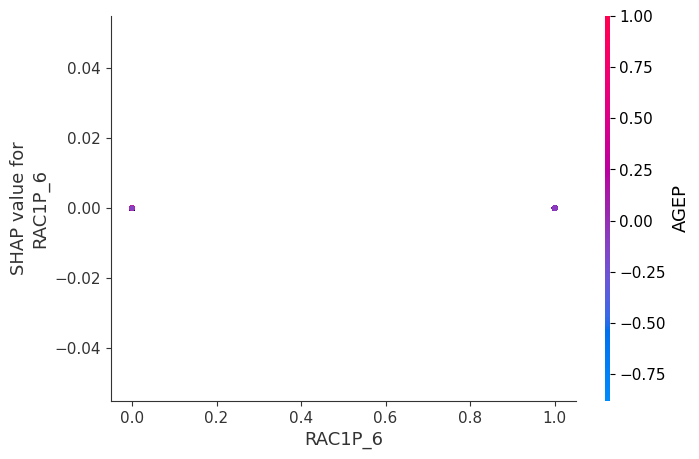

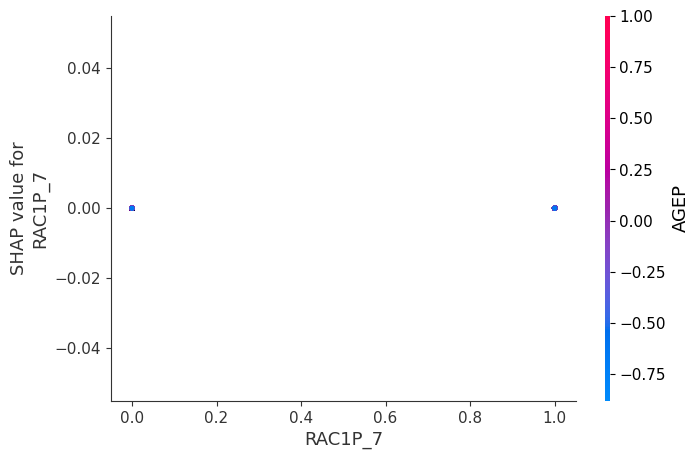

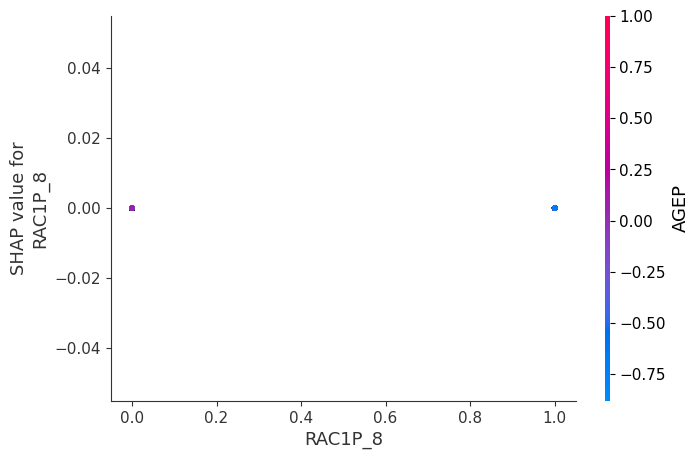

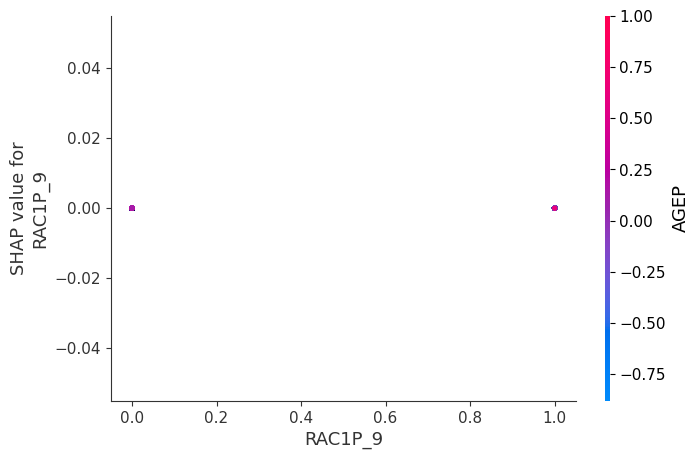

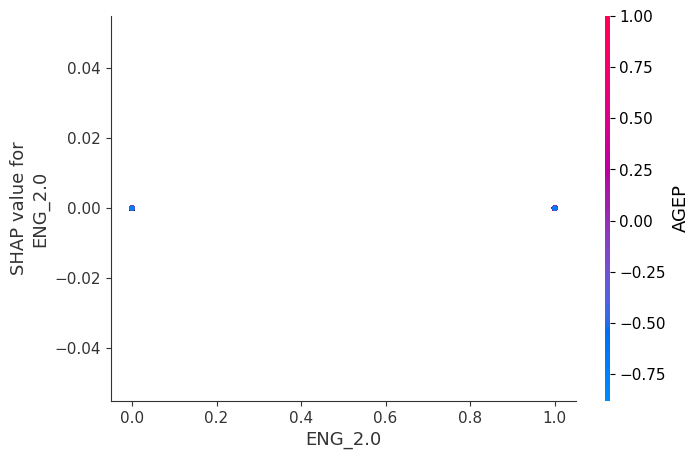

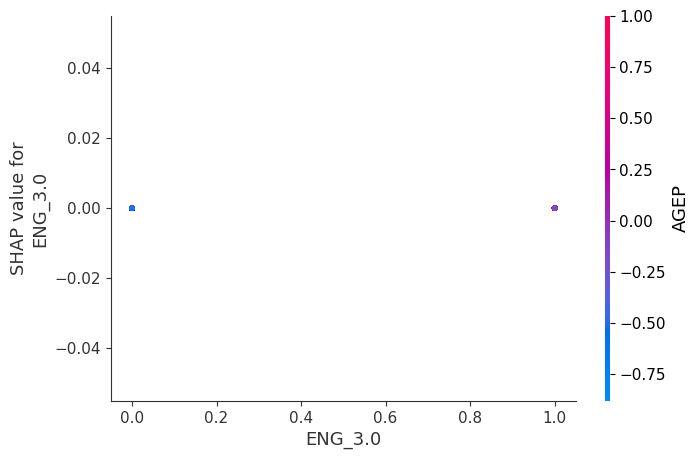

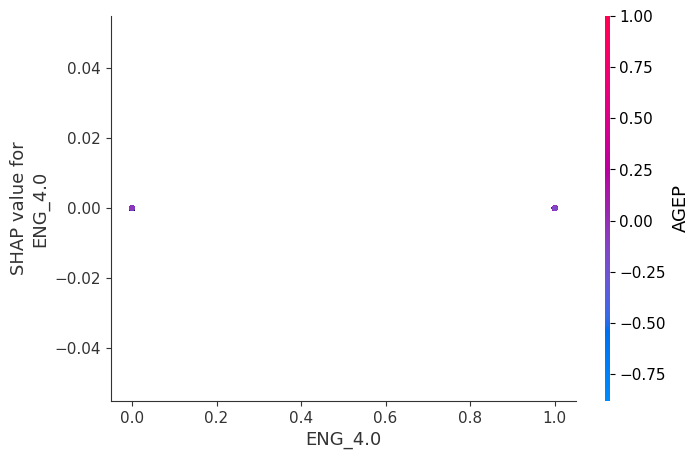

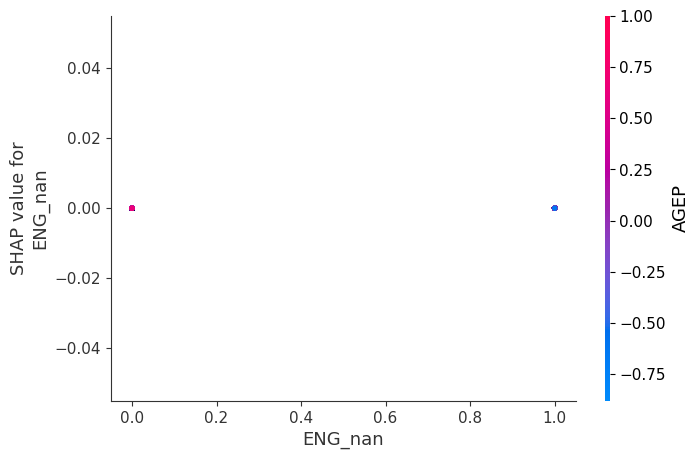

In [292]:
for name in X_train.columns: 
    shap.dependence_plot(name, shap_values[1], X_test)

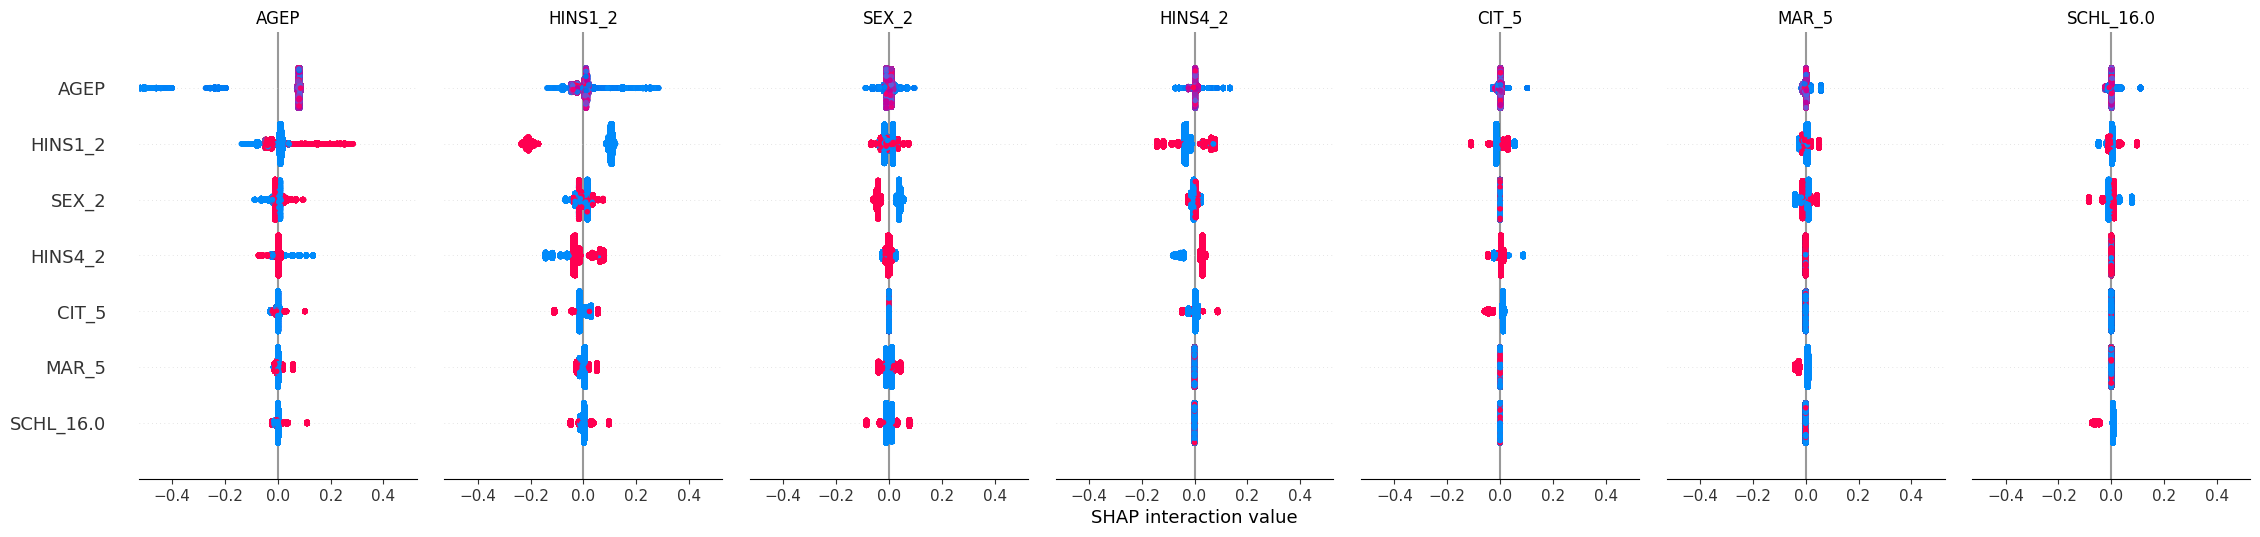

In [306]:

# Create the SHAP summary plot
shap.summary_plot(shap_interaction_values[1], X_test, show = False)

# Get the current figure
fig = plt.gcf()

# Set the figure size, to avoid having overs
fig.set_size_inches(24, 5)

# Show the plot
plt.show()

In [307]:
print("THE END")

THE END
